In [22]:
import cv2
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style

plt.rcParams["font.family"] = "STIXGeneral"
import numpy as np

### Lab Task

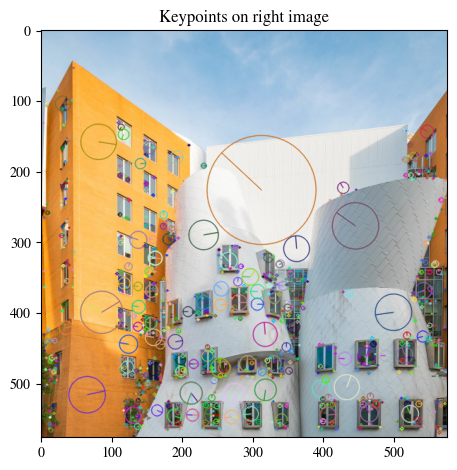

In [23]:
# Load the images
img1_path = "left.png"
img2_path = "right.png"
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

plt.imshow(img1[:, :, ::-1])
plt.tight_layout()
plt.title("Left image")
plt.savefig("plt_left.png", dpi=300, bbox_inches="tight", pad_inches=0)

plt.imshow(img2[:, :, ::-1])
plt.tight_layout()
plt.title("Right image")
plt.savefig("plt_right.png", dpi=300, bbox_inches="tight", pad_inches=0)

"""
Keypoint Detection and Descriptors
"""
# # Extract keypoints and descriptors using SIFT
kp1, descriptors1 = cv2.SIFT_create().detectAndCompute(img1, None)
kp2, descriptors2 = cv2.SIFT_create().detectAndCompute(img2, None)

# Extract keypoints and descriptors using ORB
# kp1, descriptors1 = cv2.ORB_create().detectAndCompute(img1, None)
# kp2, descriptors2 = cv2.ORB_create().detectAndCompute(img2, None)

# Visualize keypoints
img1_kp = cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp = cv2.drawKeypoints(img2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(img1_kp[:, :, ::-1])
plt.tight_layout()
plt.title("Keypoints on left image")
plt.savefig("plt_left_kp.png", dpi=300, bbox_inches="tight", pad_inches=0)

plt.imshow(img2_kp[:, :, ::-1])
plt.tight_layout()
plt.title("Keypoints on right image")
plt.savefig("plt_right_kp.png", dpi=300, bbox_inches="tight", pad_inches=0)

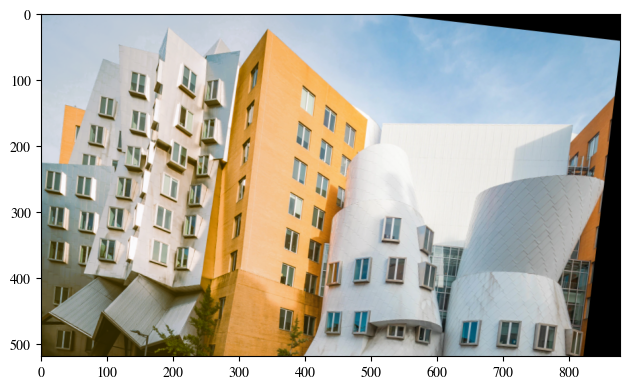

In [24]:
"""
Feature Matching
"""
# Set parameters for matching
ratio = 0.75
min_match = 10
smoothing_window_size = 200

# Brute force matcher
matcher = cv2.BFMatcher()
raw_matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

# Filter the matches using the ratio test
good_points = []
good_matches = []
for m1, m2 in raw_matches:
    if m1.distance < ratio * m2.distance:
        good_points.append((m1.trainIdx, m1.queryIdx))
        good_matches.append([m1])

plt.imshow(
    cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)[:, :, ::-1]
)
plt.tight_layout()
plt.savefig("plt_matches.png", dpi=300, bbox_inches="tight", pad_inches=0)

"""
Homography Estimation using RANSAC
"""
if len(good_points) > min_match:
    image1_kp = np.float32([kp1[i].pt for (_, i) in good_points])
    image2_kp = np.float32([kp2[i].pt for (i, _) in good_points])
    H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC, 5.0)
else:
    raise AssertionError(
        Fore.RED
        + Style.BRIGHT
        + "Error: Not enough matches were found - %d/%d" % (len(good_points), min_match)
        + Style.RESET_ALL
    )


# Function to create a mask for blending
def create_mask(img1, img2, version):
    # Calculate dimensions
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 + width_img2
    offset = int(smoothing_window_size / 2)

    barrier = img1.shape[1] - int(smoothing_window_size / 2)
    mask = np.zeros((height_panorama, width_panorama))
    # Create mask
    if version == "left_image":
        # Increase linearly from 1 to 0 from left to right
        mask[:, barrier - offset : barrier + offset] = np.tile(
            np.linspace(1, 0, 2 * offset).T, (height_panorama, 1)
        )
        mask[:, : barrier - offset] = 1
    elif version == "right_image":
        # Increase linearly from 0 to 1 from left to right
        mask[:, barrier - offset : barrier + offset] = np.tile(
            np.linspace(0, 1, 2 * offset).T, (height_panorama, 1)
        )
        mask[:, barrier + offset :] = 1
    return cv2.merge([mask, mask, mask])  # Across all three channels


# Calculate dimensions for panorama
height_img1 = img1.shape[0]
width_img1 = img1.shape[1]
width_img2 = img2.shape[1]
height_panorama = height_img1
width_panorama = width_img1 + width_img2

"""
Blending and Image Warping
"""
# Create panorama with left image
panorama1 = np.zeros((height_panorama, width_panorama, 3))
mask1 = create_mask(img1, img2, version="left_image")
panorama1[0 : img1.shape[0], 0 : img1.shape[1], :] = img1
panorama1 *= mask1

# Create panorama with right image
mask2 = create_mask(img1, img2, version="right_image")
panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama)) * mask2

# Combine panoramas and crop
result = panorama1 + panorama2
left = 0
right = result.shape[1]
for col in range(result.shape[1]):
    if np.sum(result[:, col]) != 0:
        left = col
        break
for col in range(result.shape[1] - 1, 0, -1):
    if np.sum(result[:, col]) != 0:
        right = col
        break
result = result[:, left:right, :]

# Convert to uint8 and clip to range 0-255
panorama = np.clip(result, 0, 255).astype(np.uint8)

# Display and save the result
plt.imshow(panorama[:, :, ::-1])
plt.tight_layout()
plt.savefig("plt_stitched.png", dpi=300, bbox_inches="tight", pad_inches=0)